In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import linalg
import os
from math import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [5]:
class FractionalBM:
    def __init__(self,
                 h,
                 days,timestep=1):
        
        self.h = h
        self.days = days
        self.cholesky_matrix = None
        self.fbm = None
        self.timestep = timestep
        
        
    def generate(self):
        
        nb_points = int(self.days/self.timestep)
        covar_matrix = np.zeros((nb_points,
                                 nb_points))
        
        scale_range = 0.0001+(1/252)*np.arange(nb_points)
        #scale_range = np.arange(1,self.days+1,self.timestep)
        for j,t_j in enumerate(scale_range):
            for i,t_i in enumerate(scale_range):
                covar_matrix[i][j] = 0.5*(t_i**(2*self.h) + t_j**(2*self.h) -np.abs(t_i-t_j)**(2*self.h))
        lower_cholesky_matrix = linalg.cholesky(covar_matrix , 
                                                      lower = True)
        
        self.cholesky_matrix = lower_cholesky_matrix
        
        random_normal_variables = np.random.normal(0,1,nb_points)
        
        fractional_bm = np.dot(lower_cholesky_matrix,
                              random_normal_variables)
        
        self.fbm = fractional_bm
        return fractional_bm
    
    def rough_vol(self,nu,sigma0=0.1):
        return sigma0*np.exp(nu*self.fbm)
    
    def plot_rough_vol(self,nu,sigma0):
        y = self.rough_vol(nu,sigma0)
        x = np.arange(0,self.days,self.timestep)
        plt.plot(x,y)
        plt.show()
        
    
    
def generate_corr_brownian(corr,dt):

    cov = [[dt, 0],
           [0, dt]]
    
    mean = [0, 0]
    (dWt_1,dWt_2) = np.random.multivariate_normal(mean = mean,
                                                  cov = cov)

    return corr*dWt_1 + np.sqrt(1-corr**2)*dWt_2


In [6]:

def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(linalg.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = linalg.cholesky(B)
        return True
    except linalg.LinAlgError:
        return False

## Simulation of FBM

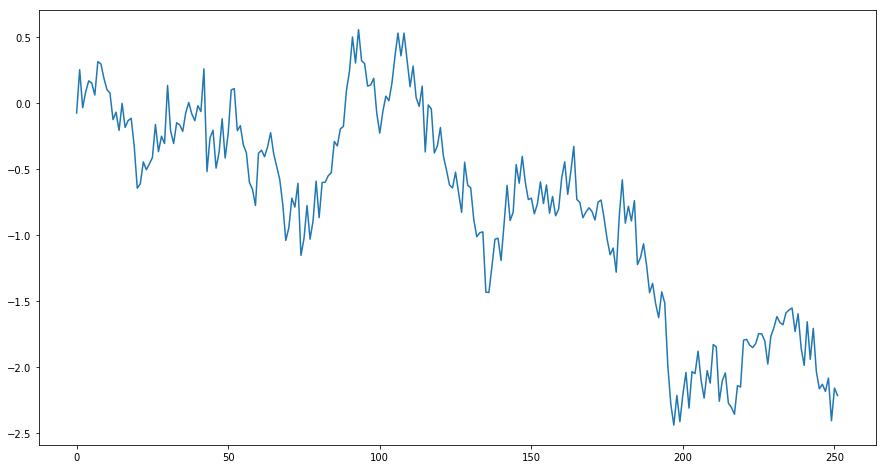

In [51]:
fbm = FractionalBM(h = 0.3,
                   days = 252,timestep=1)

plt.figure(figsize= (15,8))
for i in range(1):
    fbm.generate()
    plt.plot(fbm.fbm)
    #fbm.plot_rough_vol(nu=1,sigma0=0.02)
plt.show()

## Rough Vol model

We consider the following model without leverage effect over the time interval [0, T]:
$$ d \log \ S_{t} = \sigma_{t}dZ_{t}, \ \ \ \ d \log \ \sigma_{t} = \eta dW_{t}^{H}$$
Here $Z_{t}$ is a Brownian motion, $W_{t}^{H}$ a fractional Brownian motion independent of $Z_{t}$ and η > 0.

In [285]:
class Configuration:
    def __init__(self, NumberOfScenarios, TimeStep, T_max):
        self.NumberOfScenarios=NumberOfScenarios 
        self.TimeStep = TimeStep
        self.T_max = T_max

class OptionTrade:
    def __init__(self, stock_price, strike_price, risk_free_rate,time_to_maturity):
        self.stock_price=stock_price
        self.strike_price=strike_price
        self.risk_free_rate = risk_free_rate
        self.time_to_maturity = time_to_maturity

class RoughVol:
    def __init__(self, Configuration, H, nu, T_max,sigma0=0.1):
        self.Configuration = Configuration
        self.H = H
        self.nu = nu
        self.sigma0 = sigma0
        self.t_max = T_max
    def SimulateRoughVol(self):
        Timestep = self.Configuration.TimeStep
        fbm = FractionalBM(h = self.H, days = self.t_max, timestep=Timestep)
        fractional_bm = fbm.generate()
        self.fbm_simul = fractional_bm
        vol = fbm.rough_vol(nu=self.nu, sigma0=self.sigma0)
        return vol
        
    
class Model_stochVol:
    def __init__(self, Configuration, H, nu, corr, T_max, sigma0=0.1):
        self.Configuration = Configuration
        self.H = H
        self.nu = nu
        self.corr = corr
        self.sigma0 = sigma0
        self.t_max = T_max
    def Simulate_fbm_bm(self):
        T = self.t_max
        timestep = self.Configuration.TimeStep
        h = self.H
        rho = self.corr
        nb_points = int(T/timestep)
        covar_matrix_frac = np.zeros((nb_points,
                                         nb_points))

        scale_range = 0.0001+(1/np.sqrt(252))*np.arange(nb_points)
        #scale_range = np.arange(1,days+1,timestep)
        for j,t_j in enumerate(scale_range):
            for i,t_i in enumerate(scale_range):
                covar_matrix_frac[i][j] = 0.5*(t_i**(2*h) + t_j**(2*h) -np.abs(t_i-t_j)**(2*h))

        covar_matrix_brow = np.zeros((nb_points,
                                         nb_points))        
        for j,t_j in enumerate(scale_range):
            for i,t_i in enumerate(scale_range):
                covar_matrix_brow[i][j] = min(t_i,t_j)


        covar_matrix_fbm_bm = np.zeros((nb_points,
                                 nb_points)) 
        for j,t_j in enumerate(scale_range):
            for i,t_i in enumerate(scale_range):
                covar_matrix_fbm_bm[i][j] = rho*(t_j**0.5)*(t_i**h)

        part_1 = np.concatenate([covar_matrix_frac,covar_matrix_fbm_bm], axis=1)
        part_2 = np.concatenate([np.transpose(covar_matrix_fbm_bm),covar_matrix_brow], axis=1)  
        #print(covar_matrix)

        covar_matrix_all = np.concatenate([part_1,part_2], axis=0)

        covar_matrix_all = covar_matrix_all + 0.01*np.identity(len(covar_matrix_all))
        covar_matrix_all_PD = nearestPD(covar_matrix_all)
        lower_cholesky_matrix = linalg.cholesky(covar_matrix_all_PD , 
                                                      lower = True)
        random_normal_variables = np.random.normal(0,1,nb_points*2)
        fbm_bm = np.dot(lower_cholesky_matrix,random_normal_variables)
        fbm = fbm_bm[:nb_points]
        bm = fbm_bm[nb_points:]
        lower_cholesky_matrix_fbm = linalg.cholesky(covar_matrix_frac , 
                                                      lower = True)
        lower_cholesky_matrix_bm = linalg.cholesky(covar_matrix_brow , 
                                                      lower = True)
        fbm_noncorr = np.dot(lower_cholesky_matrix_fbm,
                      random_normal_variables[:nb_points])
        bm_noncorr = np.dot(lower_cholesky_matrix_bm,
                      random_normal_variables[nb_points:])
        return fbm_noncorr,bm_noncorr
        
    def SimulateRoughVol(self, fbm):
        return self.sigma0*np.exp(self.nu*fbm)
        
    #simulate risk factors using GBM stochastic differential equation
    def SimulateRiskFactor(self, stock_price0, T_max=1):
        simulation_df = pd.DataFrame()
        # for this example, we only are concerned with one time step as it’s an European option
        timestep = self.Configuration.TimeStep
        nb_points = int(T_max/timestep)
        dt = timestep
        for scenarioNumber in range(self.Configuration.NumberOfScenarios):
            prices = []
            fbm,bm = self.Simulate_fbm_bm()
            Rvol = self.SimulateRoughVol(fbm)
            uncertainty = Rvol[0]*np.sqrt(dt)*bm[0]

            price = stock_price0 * np.exp(uncertainty)
            prices.append(price)
            for y in range(1,nb_points):
                uncertainty = Rvol[y]*np.sqrt(dt)*bm[y]
                price = prices[y-1] * np.exp(uncertainty)
                prices.append(price)
            simulation_df[scenarioNumber] = prices
            
        return simulation_df
    
class OptionTradePayoffPricer:
    def CalculatePrice(self, trade, df_prices_per_scenario, configuration):
        pay_offs = 0
        total_scenarios = configuration.NumberOfScenarios
        for i in range(total_scenarios):
            price = df_prices_per_scenario[i].values.tolist()[-1]
            pay_offs=pay_offs+max(price - trade.strike_price,0)
                
        discounted_price = (np.exp(-1.0*trade.risk_free_rate * (trade.time_to_maturity/365))*pay_offs)
        result = discounted_price/total_scenarios
        return result
    
class MonteCarloEngineSimulator:
    
    #instationate with configuration and the model
    def __init__(self, configuration, model):
        self.configuration = configuration
        self.model = model
        
    #simulate trade and calculate price    
    def Simulate(self, stock_price0, display=True):
        nb_scenarios = self.configuration.NumberOfScenarios
        timestep = self.configuration.TimeStep
        T_max = self.configuration.T_max
        df_prices_per_scenario = self.model.SimulateRiskFactor(stock_price0, T_max=T_max)
        #print(df_prices_per_scenario)
        #plot scenarios
        if display:
            plot_scenario_paths(df_prices_per_scenario, nb_scenarios)
        return df_prices_per_scenario

    

In [286]:
def plot_scenario_paths(df_prices_per_scenario, nb_scenarios):
    plt.figure(figsize=(14,8))
    for i in range(nb_scenarios):            
        plt.plot(df_prices_per_scenario.index, df_prices_per_scenario[i])            

    plt.ylabel('Stock Value')
    plt.xlabel('Timestep')
    plt.show()

In [287]:
from scipy.stats import norm

n = norm.pdf
N = norm.cdf

def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    d2 = d1-v*sqrt(T)
    if cp_flag == 'c':
        price = S*exp(-q*T)*N(d1)-K*exp(-r*T)*N(d2)
    else:
        price = K*exp(-r*T)*N(-d2)-S*exp(-q*T)*N(-d1)
    return price

def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    return S * sqrt(T)*n(d1)

In [1]:
def find_imp_vol(target_value, S, K, T, r, call_put="c"):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 2
    for i in range(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        price = price
        diff = target_value - price  # our root

        #print(i, sigma, diff)

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

In [289]:
class RSV_MC:
    
    #instationate with configuration and the model
    def __init__(self, stock_price = 200,Rf = 0.05,nb_scenarios = 1000, T_max=250,
                             timestep = 1, sigma0=0.1, H = 0.04,nu = 1,corr = -0.4):
        self.stock_price = stock_price
        self.Rf = Rf
        #self.nb_scenarios = nb_scenarios
        self.sigma0 = sigma0
        self.H = H
        self.nu = nu
        self.corr = corr
        self.configuration = Configuration(nb_scenarios, timestep, T_max) # config
    def simulate_paths(self, display=True):    
        model = Model_stochVol(self.configuration, self.H, self.nu, self.corr, self.configuration.T_max, self.sigma0)
        simulator = MonteCarloEngineSimulator(self.configuration, model)
        df_paths = simulator.Simulate(self.stock_price, display=display)
        self.df_paths = df_paths
    def compute_option_price(self, strike, maturity_days):
        trade = OptionTrade(self.stock_price, strike, self.Rf, maturity_days) # trade
        tradePricer = OptionTradePayoffPricer()
        df_prices_per_scenario_mat = self.df_paths.loc[:int(maturity_days)]
        option_price = tradePricer.CalculatePrice(trade, df_prices_per_scenario_mat, self.configuration)

        print("option price with Monte carlo method : ",option_price)        
        return option_price

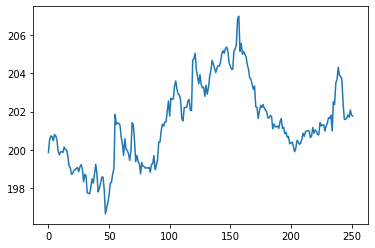

In [290]:
rsv_model.df_paths[5].plot()

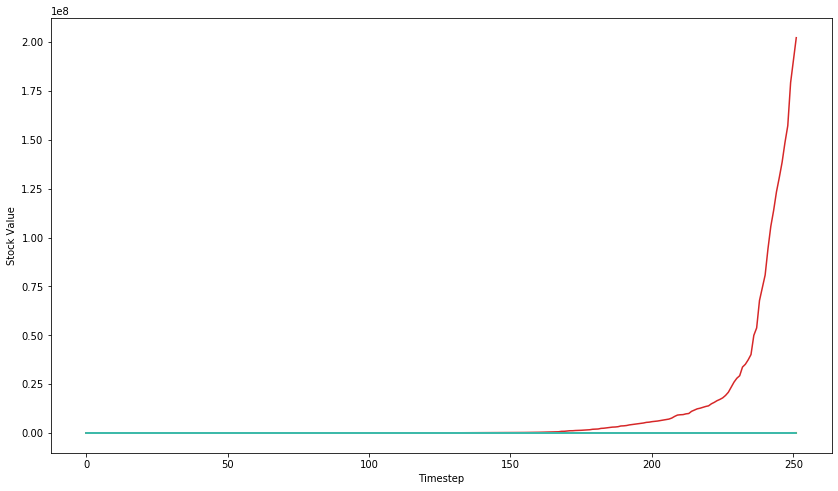

option price with Monte carlo method :  0.8222400895506066
implied vol with BS formula inversion :  0.06398226476626104


In [291]:
T_max = 1
nb_points = 252
timstep = T_max/nb_points
rsv_model = RSV_MC(stock_price = 200,Rf = 0.05,nb_scenarios = 10, T_max=T_max,
                         timestep = timstep, sigma0=0.1, H = 0.04,nu = 1,corr = 0)
rsv_model.simulate_paths(display=True)
mat_option_days = 5
mat_option_year = mat_option_days/nb_points
option_price = rsv_model.compute_option_price(strike = 200,maturity_days = mat_option_days)
iv = find_imp_vol(option_price,200,200,mat_option_year,r=0.05)
print("implied vol with BS formula inversion : ",iv)

## Use of the model to simulate implied volatilities for the date 20180108 for different maturities and strikes : simulated volatility surface

In [67]:
def read_data(date,index="SPY",indicator="impliedV"):
    path = os.path.join("data",indicator,index,date+"_"+index+"~market__"+indicator+".csv")
    df = pd.read_csv(path)
    return(df)

In [68]:
def get_iv_atm(expiry,df):
    df1 = df[df.expiry == expiry]
    df_bis = df1.drop_duplicates("expiry")
    df_bis["strike"] = df_bis["fwd"]
    df_bis["midImpliedV"] = np.nan
    df1 = df1.append(df_bis,ignore_index=True)
    df1.sort_values("strike",inplace=True)
    df1["midImpliedV"] = df1["midImpliedV"].interpolate()
    return(df1[df1["strike"] == df1["fwd"]]["midImpliedV"].values[0])

In [69]:
def add_iv_atm_col(df):
    def change_iv_atm(r,expiry,v):
        if r["expiry"]==expiry:
            r["IV_ATM"]=v
        return r
    # compute of IV_ATM of each expiry and add it to the column df["IV_ATM"]
    df["IV_ATM"] = np.nan
    for expiry in df.expiry.unique():
        v = get_iv_atm(expiry,df)
        df = df.apply(lambda r: change_iv_atm(r,expiry,v), axis=1)
    return df


In [70]:
df_iv = read_data("20180108")
df_iv["expiry"] = df_iv["expiry"].astype("str")
df_iv["expiry"] = pd.to_datetime(df_iv["expiry"],format="%Y-%m-%d")

In [71]:
df_iv = add_iv_atm_col(df_iv)
df_iv["Moneyness"] = np.log(df_iv["strike"]/df_iv["fwd"])/(np.sqrt(df_iv["tenor"])*df_iv["IV_ATM"])

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [72]:
df_iv.head()

,expiry,cleanExpiry,dow,tenor,vTenor,spot,fwd,strike,pcIndicator,volume,openInterest,bidPrice,offerPrice,midPrice,bidImpliedV,offerImpliedV,midImpliedV,criticalSpot,IV_ATM,Moneyness
0,2018-01-10,20180110,W,0.005451,0.005815,273.972444,273.934799,265.5,-1.0,101.0,1136.0,0.01,0.02,0.015,0.171806,0.188126,0.180908,-1.0,0.061269,-6.913917
1,2018-01-10,20180110,W,0.005451,0.005815,273.972444,273.934799,266.0,-1.0,10.0,2708.0,0.01,0.02,0.015,0.162738,0.178330,0.171419,-1.0,0.061269,-6.497987
2,2018-01-10,20180110,W,0.005451,0.005815,273.972444,273.934799,266.5,-1.0,50.0,5670.0,0.01,0.02,0.015,0.153594,0.168488,0.161871,-1.0,0.061269,-6.082839
3,2018-01-10,20180110,W,0.005451,0.005815,273.972444,273.934799,267.0,-1.0,354.0,4730.0,0.01,0.02,0.015,0.144338,0.158635,0.152265,-1.0,0.061269,-5.668468
4,2018-01-10,20180110,W,0.005451,0.005815,273.972444,273.934799,267.5,-1.0,316.0,6800.0,0.01,0.02,0.015,0.135104,0.148615,0.142643,-1.0,0.061269,-5.254873


In [73]:
df_iv_groupBy = df_iv.groupby(["tenor","strike","expiry"]).mean()
df_iv_groupBy.reset_index("expiry",inplace=True)

In [74]:
df_iv_groupBy

expiry  cleanExpiry    vTenor        spot         fwd  \
tenor    strike                                                             
0.005451 265.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         266.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         266.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         267.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         267.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         268.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         268.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         269.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         269.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         270.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         270.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         271.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         271.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         272.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         272.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         273.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         273.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         274.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         274.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         275.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
0.010930 256.0  2018-01-12     20180112  0.011660  273.972444  273.996289   
         257.0  2018-01-12     20180112  0.011660  273.972444  273.996289   
         257.5  2018-01-12     20180112  0.011660  273.972444  273.996289   
         258.0  2018-01-12     20180112  0.011660  273.972444  273.996289   
         259.0  2018-01-12     20180112  0.011660  273.972444  273.996289   
         260.0  2018-01-12     20180112  0.011660  273.972444  273.996289   
         261.0  2018-01-12     20180112  0.011660  273.972444  273.996289   
         262.0  2018-01-12     20180112  0.011660  273.972444  273.996289   
         262.5  2018-01-12     20180112  0.011660  273.972444  273.996289   
         263.0  2018-01-12     20180112  0.011660  273.972444  273.996289   
...                    ...          ...       ...         ...         ...   
0.950656 281.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         282.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         283.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         284.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         285.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         286.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         287.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         288.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         289.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         290.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         291.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         292.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         293.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         294.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         295.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         296.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         297.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         298.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         299.0  2018-12-21     20181221  0.952768  273.972444  274.504743   
         300.0  

In [75]:
dic_params={0:{"H":0.3,"nu":0.06,"corr":0},1:{"H":0.13,"nu":0.3,"corr":0},
            2:{"H":0.04,"nu":1,"corr":0},3:{"H":0.33,"nu":1,"corr":0},
            4:{"H":0.3,"nu":0.3,"corr":0},5:{"H":0.36,"nu":0.03,"corr":0},6:{"H":0.13,"nu":0.2,"corr":0}}
            

In [82]:
def find_sigma0(df_iv_groupBy,min_maturity):
    df_min_mat = df_iv_groupBy.loc[min_maturity].reset_index()
    sigma0 = df_min_mat["IV_ATM"].unique()[0]
    return sigma0

def compute_iv_roughVol_fixedDate(df_iv_groupBy, index_dic_param = 2, tenor_min=0,tenor_max = 1):
    tenor_list_unique = sorted(df_iv_groupBy.index.get_level_values(0).unique())
    df_iv_groupBy["iv_rough_vol_"+str(index_dic_param)] = np.nan
    H = dic_params[index_dic_param]["H"]
    nu = dic_params[index_dic_param]["nu"]
    corr = dic_params[index_dic_param]["corr"]
    spot = df_iv_groupBy["spot"].values[0]
    print("spot :",spot)
    sigma0 = find_sigma0(df_iv_groupBy,tenor_list_unique[0])
    print("sigma0 :",sigma0)
    #sigma0 = 0.15
    rsv_mc = RSV_MC(stock_price=spot, Rf=0.05, nb_scenarios=10, T_max = 1,
                         timestep_days=(1/252), sigma0=sigma0, H = H, nu=nu, corr=corr)
    rsv_mc.simulate_paths(display=True)
    nb_options = 0
    for tenor in tenor_list_unique:
        if (tenor>=tenor_min) and (tenor<=tenor_max):
            strike_list = df_iv_groupBy.loc[tenor].index
            for strike in strike_list:
                maturity_days = int(tenor*365)+1
                mat_year = maturity_days/365
                print("maturity in days : "+str(maturity_days)+" , strike : "+str(strike))
                option_price = rsv_model.compute_option_price(strike = strike, maturity_days = maturity_days)
                iv = find_imp_vol(option_price,spot,strike,mat_year,r=0.05)
                print("implied vol with BS formula inversion : ",iv)
                df_iv_groupBy.loc[(tenor,strike),"iv_rough_vol_"+str(index_dic_param)] = iv
                nb_options+=1
        elif tenor>=tenor_max:
            break;
    print("total number of options priced :",nb_options)
    return df_iv_groupBy

spot : 273.97244356448954
sigma0 : 0.06126922304609869


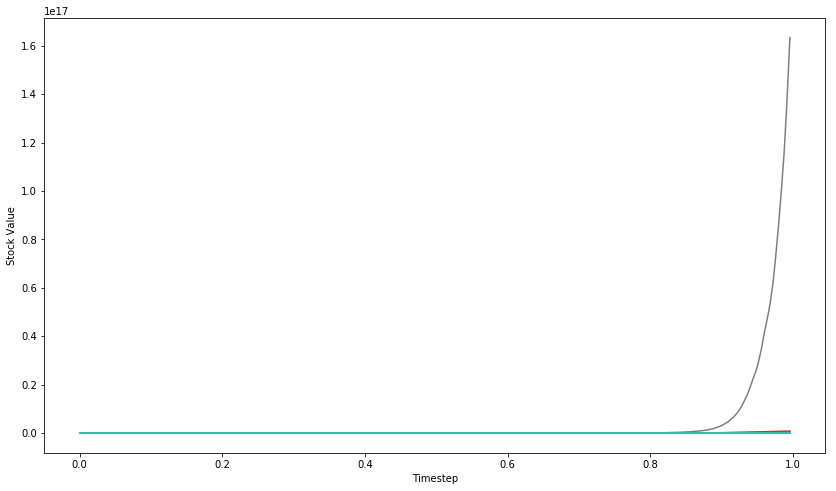

maturity in days : 2 , strike : 265.5
option price with Monte carlo method :  28.42733823641409
implied vol with BS formula inversion :  3.008795324316545
maturity in days : 2 , strike : 266.0
option price with Monte carlo method :  28.177406720183008
implied vol with BS formula inversion :  3.0094730331045185
maturity in days : 2 , strike : 266.5
option price with Monte carlo method :  27.92747520395192
implied vol with BS formula inversion :  3.009934114856928
maturity in days : 2 , strike : 267.0
option price with Monte carlo method :  27.677543687720846
implied vol with BS formula inversion :  3.010180351865282
maturity in days : 2 , strike : 267.5
option price with Monte carlo method :  27.427612171489763
implied vol with BS formula inversion :  3.010213434433976
maturity in days : 2 , strike : 268.0
option price with Monte carlo method :  27.177680655258676
implied vol with BS formula inversion :  3.010034963289021
maturity in days : 2 , strike : 268.5
option price with Monte car

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

overflow encountered in double_scalars

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

overflow encountered in double_scalars

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

divide by zero encountered in double_scalars

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in double_scalars

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in double_scalars



implied vol with BS formula inversion :  nan
maturity in days : 9 , strike : 265.5
option price with Monte carlo method :  2308.5470059883583
implied vol with BS formula inversion :  nan
maturity in days : 9 , strike : 266.0
option price with Monte carlo method :  2308.1974372293193
implied vol with BS formula inversion :  nan
maturity in days : 9 , strike : 266.5
option price with Monte carlo method :  2307.8478684702804
implied vol with BS formula inversion :  nan
maturity in days : 9 , strike : 267.0
option price with Monte carlo method :  2307.4982997112415
implied vol with BS formula inversion :  nan
maturity in days : 9 , strike : 267.5
option price with Monte carlo method :  2307.1487309522026
implied vol with BS formula inversion :  nan
maturity in days : 9 , strike : 268.0
option price with Monte carlo method :  2306.799162193164
implied vol with BS formula inversion :  nan
maturity in days : 9 , strike : 268.5
option price with Monte carlo method :  2306.4776104936636
implied

implied vol with BS formula inversion :  nan
maturity in days : 11 , strike : 267.5
option price with Monte carlo method :  5527.103832824642
implied vol with BS formula inversion :  nan
maturity in days : 11 , strike : 268.0
option price with Monte carlo method :  5526.7543598247485
implied vol with BS formula inversion :  nan
maturity in days : 11 , strike : 268.5
option price with Monte carlo method :  5526.404886824854
implied vol with BS formula inversion :  nan
maturity in days : 11 , strike : 269.0
option price with Monte carlo method :  5526.055413824959
implied vol with BS formula inversion :  nan
maturity in days : 11 , strike : 269.5
option price with Monte carlo method :  5525.705940825065
implied vol with BS formula inversion :  nan
maturity in days : 11 , strike : 270.0
option price with Monte carlo method :  5525.3564678251705
implied vol with BS formula inversion :  nan
maturity in days : 11 , strike : 270.5
option price with Monte carlo method :  5525.006994825277
impl

implied vol with BS formula inversion :  nan
maturity in days : 18 , strike : 267.0
option price with Monte carlo method :  135914.72884522777
implied vol with BS formula inversion :  nan
maturity in days : 18 , strike : 267.5
option price with Monte carlo method :  135914.42958404258
implied vol with BS formula inversion :  nan
maturity in days : 18 , strike : 268.0
option price with Monte carlo method :  135914.13032285735
implied vol with BS formula inversion :  nan
maturity in days : 18 , strike : 269.0
option price with Monte carlo method :  135913.5318004869
implied vol with BS formula inversion :  nan
maturity in days : 18 , strike : 270.0
option price with Monte carlo method :  135912.93327811648
implied vol with BS formula inversion :  nan
maturity in days : 18 , strike : 271.0
option price with Monte carlo method :  135912.33475574607
implied vol with BS formula inversion :  nan
maturity in days : 18 , strike : 272.0
option price with Monte carlo method :  135911.73623337565


implied vol with BS formula inversion :  nan
maturity in days : 25 , strike : 271.0
option price with Monte carlo method :  236827.64226545548
implied vol with BS formula inversion :  nan
maturity in days : 25 , strike : 272.0
option price with Monte carlo method :  236827.04431673553
implied vol with BS formula inversion :  nan
maturity in days : 25 , strike : 272.5
option price with Monte carlo method :  236826.74534237557
implied vol with BS formula inversion :  nan
maturity in days : 25 , strike : 273.0
option price with Monte carlo method :  236826.44636801555
implied vol with BS formula inversion :  nan
maturity in days : 25 , strike : 274.0
option price with Monte carlo method :  236825.84841929562
implied vol with BS formula inversion :  nan
maturity in days : 25 , strike : 275.0
option price with Monte carlo method :  236825.2504705757
implied vol with BS formula inversion :  nan
maturity in days : 25 , strike : 276.0
option price with Monte carlo method :  236824.65252185572


implied vol with BS formula inversion :  nan
maturity in days : 39 , strike : 229.0
option price with Monte carlo method :  236398.9532418144
implied vol with BS formula inversion :  nan
maturity in days : 39 , strike : 230.0
option price with Monte carlo method :  236398.3564387465
implied vol with BS formula inversion :  nan
maturity in days : 39 , strike : 231.0
option price with Monte carlo method :  236397.75963567858
implied vol with BS formula inversion :  nan
maturity in days : 39 , strike : 232.0
option price with Monte carlo method :  236397.1628326107
implied vol with BS formula inversion :  nan
maturity in days : 39 , strike : 233.0
option price with Monte carlo method :  236396.56602954277
implied vol with BS formula inversion :  nan
maturity in days : 39 , strike : 234.0
option price with Monte carlo method :  236395.96922647493
implied vol with BS formula inversion :  nan
maturity in days : 39 , strike : 235.0
option price with Monte carlo method :  236395.372423407
impl

implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 187.0
option price with Monte carlo method :  235518.9240252482
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 188.0
option price with Monte carlo method :  235518.32950690357
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 189.0
option price with Monte carlo method :  235517.73498855886
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 190.0
option price with Monte carlo method :  235517.14047021413
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 191.0
option price with Monte carlo method :  235516.54595186943
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 192.0
option price with Monte carlo method :  235515.95143352472
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 193.0
option price with Monte carlo method :  235515.35691518002


implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 259.0
option price with Monte carlo method :  235476.11870442942
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 260.0
option price with Monte carlo method :  235475.5241860847
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 261.0
option price with Monte carlo method :  235474.92966773998
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 262.0
option price with Monte carlo method :  235474.33514939528
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 263.0
option price with Monte carlo method :  235473.74063105058
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 264.0
option price with Monte carlo method :  235473.14611270587
implied vol with BS formula inversion :  nan
maturity in days : 67 , strike : 265.0
option price with Monte carlo method :  235472.55159436114


implied vol with BS formula inversion :  nan
maturity in days : 102 , strike : 268.0
option price with Monte carlo method :  234344.50071693008
implied vol with BS formula inversion :  nan
maturity in days : 102 , strike : 269.0
option price with Monte carlo method :  234343.90904219347
implied vol with BS formula inversion :  nan
maturity in days : 102 , strike : 270.0
option price with Monte carlo method :  234343.3173674569
implied vol with BS formula inversion :  nan
maturity in days : 102 , strike : 271.0
option price with Monte carlo method :  234342.7256927203
implied vol with BS formula inversion :  nan
maturity in days : 102 , strike : 272.0
option price with Monte carlo method :  234342.13401798368
implied vol with BS formula inversion :  nan
maturity in days : 102 , strike : 273.0
option price with Monte carlo method :  234341.54234324707
implied vol with BS formula inversion :  nan
maturity in days : 102 , strike : 274.0
option price with Monte carlo method :  234340.950668

implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 217.0
option price with Monte carlo method :  232583.61202576762
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 218.0
option price with Monte carlo method :  232583.0248725408
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 219.0
option price with Monte carlo method :  232582.4377193139
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 220.0
option price with Monte carlo method :  232581.850566087
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 221.0
option price with Monte carlo method :  232581.26341286016
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 222.0
option price with Monte carlo method :  232580.6762596333
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 223.0
option price with Monte carlo method :  232580.089106406

implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 281.0
option price with Monte carlo method :  232546.0342192485
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 282.0
option price with Monte carlo method :  232545.44706602168
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 283.0
option price with Monte carlo method :  232544.85991279478
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 284.0
option price with Monte carlo method :  232544.2727595679
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 285.0
option price with Monte carlo method :  232543.68560634105
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 286.0
option price with Monte carlo method :  232543.0984531142
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 287.0
option price with Monte carlo method :  232542.5112998

In [83]:
df_iv_groupBy = compute_iv_roughVol_fixedDate(df_iv_groupBy,index_dic_param=1,tenor_max=0.5)

In [164]:
def plot_iv_skew(df_iv_groupBy, index_dic_param=2, exp_dates_list=["20180110","20180112","20180216","20180316",
                                                     '20180420', '20180615', '20180720', '20180921','20181221']):
    print(dic_params[index_dic_param])
    plt.figure(figsize=(16, 10))
    for i,expiry_date in  enumerate(exp_dates_list):
        ax = plt.subplot(3, 3, i+1)
        df_iv_grouBy_reset = df_iv_groupBy.reset_index("tenor")
        df_iv_grouBy_reset[df_iv_grouBy_reset["expiry"]==expiry_date][["midImpliedV"]].plot( ax=ax)
        df_iv_grouBy_reset[df_iv_grouBy_reset["expiry"]==expiry_date][["iv_rough_vol_"+str(index_dic_param)]].plot(ax=ax)
        plt.axvline(x=df_iv_grouBy_reset[df_iv_grouBy_reset["expiry"]==expiry_date]["spot"].unique(),color='red')
        plt.title("expiry date : "+expiry_date)
        plt.legend()
        plt.tight_layout()

In [165]:
def plot_term_struct(df_iv_groupBy,index_dic_param=2, strikes_list=[235,250,260,270,280,290]):
    plt.figure(figsize=(16, 10))
    for i,strike in  enumerate(strikes_list):
        ax = plt.subplot(3, 3, i+1)
        df_iv_grouBy_reset = df_iv_groupBy.reset_index("strike")
        df_term_st = df_iv_grouBy_reset[df_iv_grouBy_reset["strike"]==strike]
        df_term_st[["expiry","iv_rough_vol_"+str(index_dic_param)]].set_index("expiry").plot(ax=ax)
        df_term_st[["expiry","midImpliedV"]].set_index("expiry").plot(ax=ax)
        plt.title("Strike : "+str(strike))
        plt.tight_layout()

In [166]:
def plot_vol_surface(df,index_dic_param,x_col="expiry",y_col="strike",target_z_col="midImpliedV",tenor_max=None):
    df = df.reset_index()
    if tenor_max is not None:
        df = df[df["tenor"]<tenor_max]
    df_pivot = df.pivot(index=x_col,columns=y_col,values=target_z_col+"_"+str(index_dic_param))
    fig = go.Figure(data=[go.Surface(x=df_pivot.columns.values,y=df_pivot.index ,z=df_pivot.values)])

    fig.update_layout(title='volatility surface', autosize=False,
                      width=800, height=600,
                      margin=dict(l=65, r=50, b=65, t=90))

    fig.show()

{'H': 0.13, 'nu': 0.3, 'corr': 0}


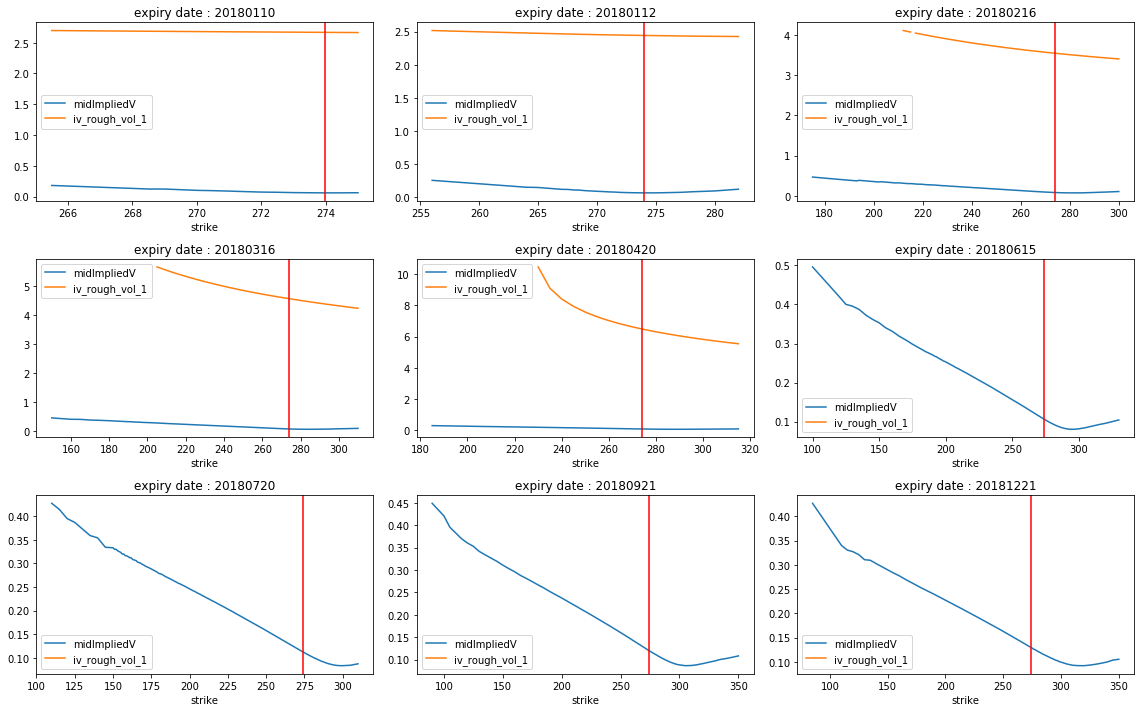

In [167]:
plot_iv_skew(df_iv_groupBy,index_dic_param=1)

{'H': 0.33, 'nu': 1, 'corr': 0}


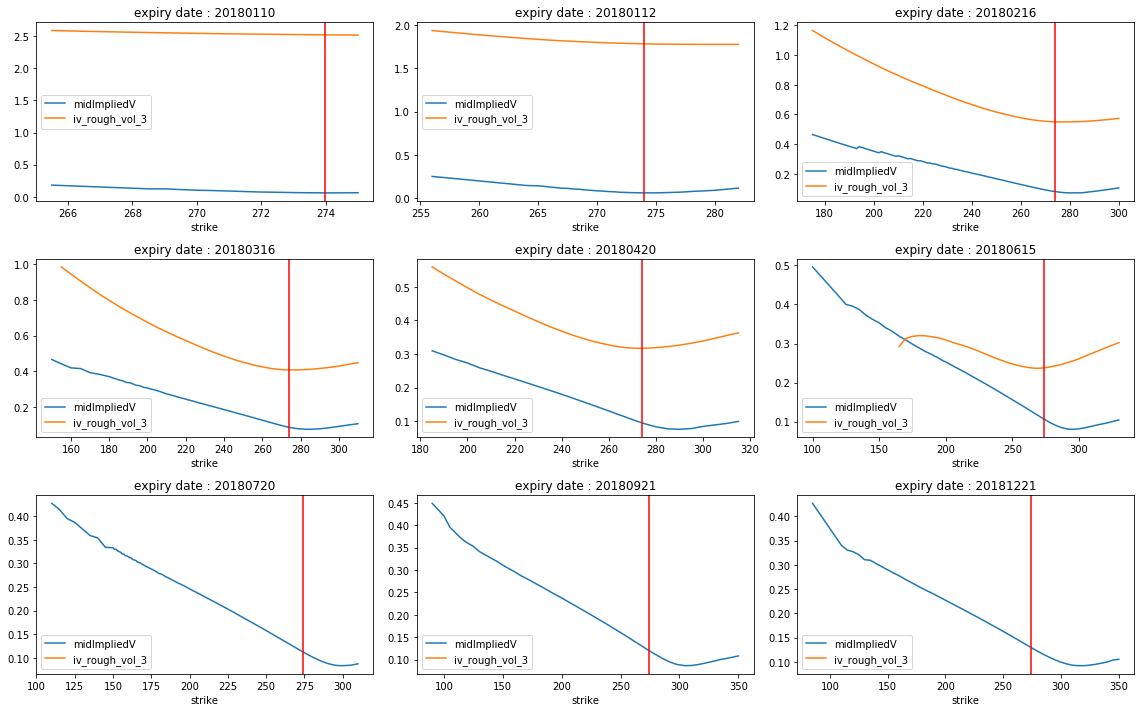

In [113]:
plot_iv_skew(df_iv_groupBy,index_dic_param=3)

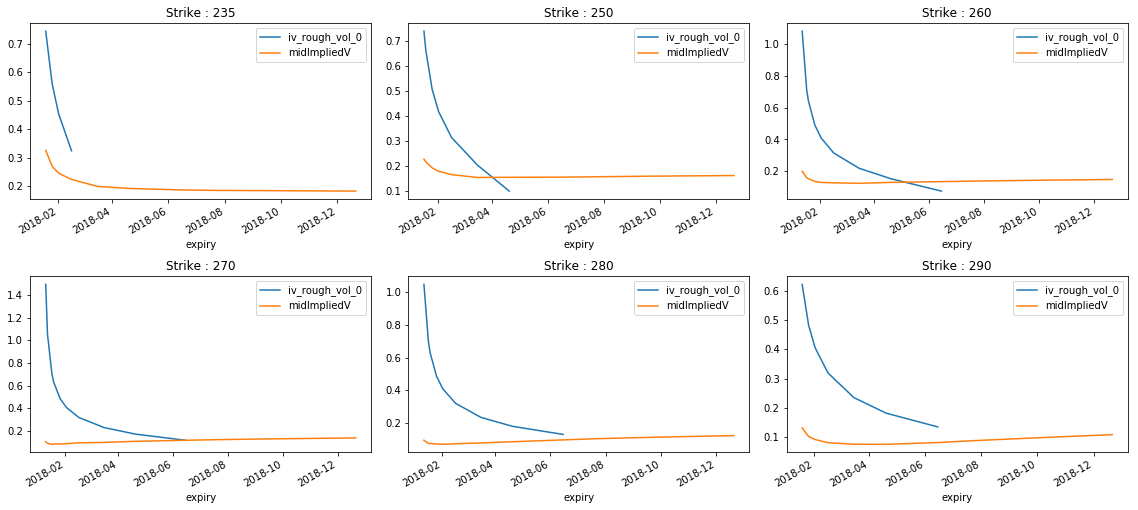

In [114]:
plot_term_struct(df_iv_groupBy,index_dic_param=0)

### the simulated iv is not compatible with reality

In [696]:
plot_vol_surface(df_iv_groupBy,target_z_col="iv_rough_vol",index_dic_param=6,tenor_max=0.5)

## Find parameters H and Nu of IV_ATM Rough model for different expiries using the Scaling of $m(q,\Delta)$ with lag $\Delta$

In [465]:
spy = pd.read_csv("SPY__constantMaturityImpliedVStatistics.csv")

In [532]:
spy.head()

,date,spot,fwd_W2,fwd_M1,fwd_W6,fwd_M2,fwd_M3,fwd_M4,fwd_M5,fwd_M6,...,conv_W2,conv_M1,conv_W6,conv_M2,conv_M3,conv_M4,conv_M5,conv_M6,level_M1_sqrt,level_M1_log_sqrt
0,20080102,145.132007,145.132007,145.370294,145.566433,145.549364,145.593860,145.837113,146.080365,146.304170,...,0.001107,-0.000293,-0.003108,-0.003999,-0.003841,-0.004252,-0.004230,-0.004136,0.470900,-0.753109
1,20080103,145.119163,145.119163,145.366847,145.556487,145.546948,145.633973,145.883753,146.133533,146.334559,...,-0.001061,-0.003243,-0.005667,-0.005967,-0.005085,-0.005292,-0.004754,-0.004224,0.466765,-0.761930
2,20080104,141.468056,141.468056,141.710360,141.886066,141.854393,141.929284,142.148660,142.368037,142.555189,...,0.000564,-0.000721,-0.002928,-0.004448,-0.006070,-0.005698,-0.004129,-0.003016,0.483857,-0.725967
3,20080107,141.801433,141.843656,142.095885,142.228671,142.207812,142.302168,142.492872,142.683576,142.871456,...,-0.001156,-0.002234,-0.002858,-0.003821,-0.004740,-0.004752,-0.003980,-0.003576,0.476630,-0.741015
4,20080108,138.987895,139.044448,139.287657,139.394845,139.356368,139.443529,139.627972,139.812415,139.979711,...,0.002408,-0.000564,-0.004317,-0.004453,-0.004463,-0.004837,-0.004655,-0.004566,0.498351,-0.696451


<h3 id="The-smoothness-of-the-volatility-process">The smoothness of the volatility process<a class="anchor-link" href="#The-smoothness-of-the-volatility-process">¶</a></h3><p>For $q\geq 0$, we define the $q$th sample moment of differences of log-volatility at a given lag $\Delta$ $\angl{\cdot}$ denotes the sample average):</p>
$$
m(q,\Delta)=<\left|\log \sigma_{t+\Delta} -\log \sigma_{t} \right|^q>
$$<p>For example</p>
$$
m(2,\Delta)=<\left(\log \sigma_{t+\Delta} -\log \sigma_{t} \right)^2>
$$<p>is just the sample variance of differences in log-volatility at the lag $\Delta$.</p>

In [541]:
maturity = "M1"
moneyness = -3

In [542]:
spy["iv_"+maturity+"_"+str(moneyness)] = spy["level_"+maturity]+spy["skew_"+maturity]*moneyness \
    +spy["conv_"+maturity]*(moneyness**2)

In [544]:
spy.head()

,date,spot,fwd_W2,fwd_M1,fwd_W6,fwd_M2,fwd_M3,fwd_M4,fwd_M5,fwd_M6,...,conv_W6,conv_M2,conv_M3,conv_M4,conv_M5,conv_M6,level_M1_sqrt,level_M1_log_sqrt,iv_M1_-6,iv_M1_-3
0,20080102,145.132007,145.132007,145.370294,145.566433,145.549364,145.593860,145.837113,146.080365,146.304170,...,-0.003108,-0.003999,-0.003841,-0.004252,-0.004230,-0.004136,0.470900,-0.753109,0.458503,0.342767
1,20080103,145.119163,145.119163,145.366847,145.556487,145.546948,145.633973,145.883753,146.133533,146.334559,...,-0.005667,-0.005967,-0.005085,-0.005292,-0.004754,-0.004224,0.466765,-0.761930,0.341971,0.309103
2,20080104,141.468056,141.468056,141.710360,141.886066,141.854393,141.929284,142.148660,142.368037,142.555189,...,-0.002928,-0.004448,-0.006070,-0.005698,-0.004129,-0.003016,0.483857,-0.725967,0.418493,0.332794
3,20080107,141.801433,141.843656,142.095885,142.228671,142.207812,142.302168,142.492872,142.683576,142.871456,...,-0.002858,-0.003821,-0.004740,-0.004752,-0.003980,-0.003576,0.476630,-0.741015,0.370920,0.319153
4,20080108,138.987895,139.044448,139.287657,139.394845,139.356368,139.443529,139.627972,139.812415,139.979711,...,-0.004317,-0.004453,-0.004463,-0.004837,-0.004655,-0.004566,0.498351,-0.696451,0.453125,0.355819


In [548]:
#col = 'level_M1'
col = "iv_"+maturity+"_"+str(moneyness)
spy[col+'_sqrt']= np.sqrt(spy[col])
spy[col+'_log_sqrt'] = np.log(spy[col+'_sqrt'])

def del_Raw(q, x): 
    return [np.mean(np.abs(spy[col+'_log_sqrt'] - spy[col+'_log_sqrt'].shift(lag)) ** q)
            for lag in x]


[0.13727780183443525, 0.2652832520868921, 0.3758876942693283, 0.4637079880564061, 0.576813259899538]


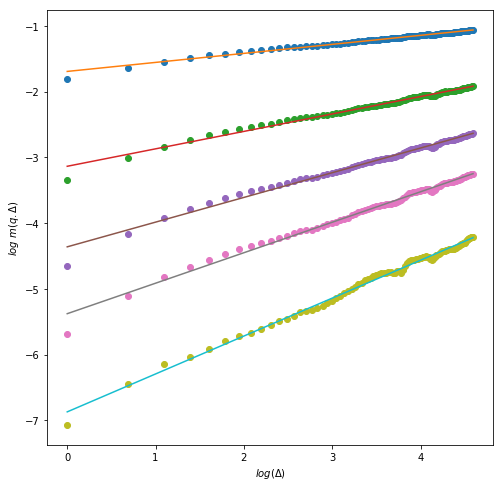

In [549]:

plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o') 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    
print(zeta_q)




<h3 id="Monofractal-scaling-result">Monofractal scaling result<a class="anchor-link" href="#Monofractal-scaling-result">¶</a></h3><ul>
<li>From the above log-log plot, we see that for each $q$, $m(q,\Delta) \propto \Delta ^{\zeta_q}$.</li>
</ul>
<ul>
<li>How does $\zeta_q$ scale with $q$?</li>
</ul>



<h3 id="Scaling-of-$\zeta_q$-with-$q$">Scaling of $\zeta_q$ with $q$<a class="anchor-link" href="#Scaling-of-$\zeta_q$-with-$q$">¶</a></h3>


0.21797900016966973


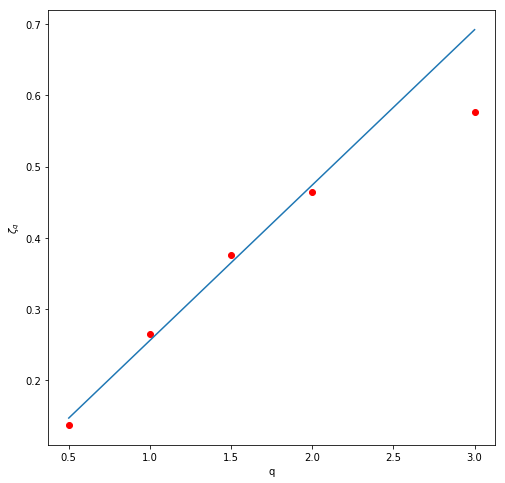

In [550]:

plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec + line[1])
h_est= line[0]
print(h_est)




<p>We find the monofractal scaling relationship</p>
$$
\zeta_q = q\,H
$$<p>with $H \approx 0.13$.</p>
<ul>
<li>Note however that $H$ does vary over time, in a narrow range.</li>
</ul>
<ul>
<li>Note also that our estimate of $H$ is biased high because we proxied instantaneous variance $v_t$ with its average over each day $\frac 1T\,\int_0^T\,v_t\,dt$, where $T$ is one trading day.</li>
</ul>


In [469]:

def dlsig2(sic, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
        print(a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]



In [556]:

h = list()
nu = list()
maturity_list = ["W2","M1","W6","M2","M3","M4","M5","M6"]
moneyness = -1
cols = []

for maturity in maturity_list:
    cols.append("iv_"+maturity+"_"+str(moneyness))
    sig = spy["level_"+maturity]+spy["skew_"+maturity]*moneyness+spy["conv_"+maturity]*(moneyness**2)
    sig = np.log(np.sqrt(sig))
    sig = sig.dropna()
    model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
    nu.append(np.sqrt(np.exp(model[1])))
    h.append(model[0]/2.)
    
stats = pd.DataFrame({'names':cols, 'h_est': h, 'nu_est': nu})

In [555]:
stats

,names,h_est,nu_est
0,iv_W2_0,0.291220,0.060695
1,iv_M1_0,0.333519,0.043747
2,iv_W6_0,0.352674,0.037214
3,iv_M2_0,0.368979,0.031544
4,iv_M3_0,0.384708,0.025979
5,iv_M4_0,0.394686,0.022543
6,iv_M5_0,0.402445,0.020197
7,iv_M6_0,0.411409,0.018302


In [557]:
stats

,names,h_est,nu_est
0,iv_W2_-1,0.254637,0.072806
1,iv_M1_-1,0.311604,0.048919
2,iv_W6_-1,0.340665,0.039832
3,iv_M2_-1,0.360692,0.033252
4,iv_M3_-1,0.380001,0.027012
5,iv_M4_-1,0.391799,0.023268
6,iv_M5_-1,0.401515,0.020722
7,iv_M6_-1,0.412223,0.018653


In [553]:
stats

,names,h_est,nu_est
0,iv_W2_-3,0.145410,0.124983
1,iv_M1_-3,0.231854,0.067964
2,iv_W6_-3,0.326783,0.038993
3,iv_M2_-3,0.355212,0.031273
4,iv_M3_-3,0.377786,0.025387
5,iv_M4_-3,0.390839,0.021940
6,iv_M5_-3,0.407065,0.019106
7,iv_M6_-3,0.421488,0.017104


In [488]:
def compute_year_frac(s):
    a=s.split("_")[1]
    if a[0] == "W":
        res = (int(a[1])*7)/365
    elif a[0] == "M":
        res = (int(a[1])*30)/365
    return res

stats["year_frac"] = stats["names"].apply(lambda s: compute_year_frac(s))

In [489]:
stats

,names,h_est,nu_est,year_frac
0,level_W2,0.291220,0.060695,0.038356
1,level_M1,0.333519,0.043747,0.082192
2,level_W6,0.352674,0.037214,0.115068
3,level_M2,0.368979,0.031544,0.164384
4,level_M3,0.384708,0.025979,0.246575
5,level_M4,0.394686,0.022543,0.328767
6,level_M5,0.402445,0.020197,0.410959
7,level_M6,0.411409,0.018302,0.493151


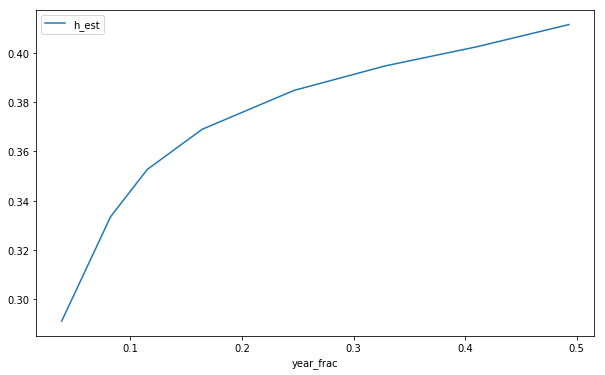

In [491]:
stats.plot(x="year_frac",y="h_est",figsize=(10,6))

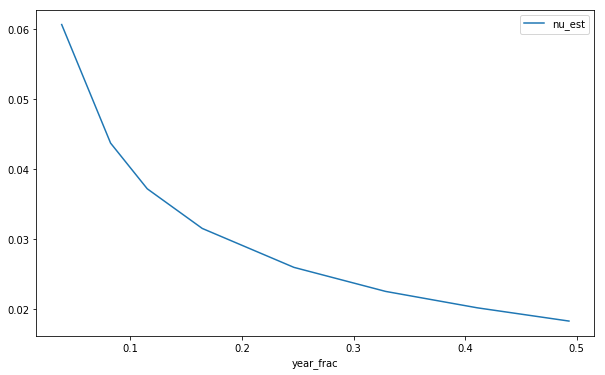

In [500]:
stats.plot(x="year_frac",y="nu_est",figsize=(10,6))

In [102]:
def f(a):
    a[0]=a[0]+1

In [103]:
a = [0]

In [104]:
f(a)

In [105]:
a

[1]